## Results Mortality


In [1]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures
from climada.hazard import Hazard
from src.impact_calculation.impact_heat import *
from src.util.plots import *

fig_dir = '../../data_analysis/figures/'

2020-12-07 10:16:52,340 - climada - DEBUG - Loading default config file: /Users/zeliestalhanske/Documents/GitHub/climada_python/climada/conf/defaults.conf


In [2]:
directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()


2020-11-30 12:03:07,005 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_O.h5
2020-11-30 12:03:08,991 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-30 12:03:08,992 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-30 12:03:08,992 - climada.entity.exposures.base - INFO - cover not set.
2020-11-30 12:03:08,993 - climada.entity.exposures.base - INFO - category_id not set.
2020-11-30 12:03:08,994 - climada.entity.exposures.base - INFO - region_id not set.
2020-11-30 12:03:08,996 - climada.entity.exposures.base - INFO - Reading ../../input_data/exposures/exposures_mortality_ch_U.h5
2020-11-30 12:03:10,954 - climada.entity.exposures.base - INFO - centr_ not set.
2020-11-30 12:03:10,955 - climada.entity.exposures.base - INFO - deductible not set.
2020-11-30 12:03:10,955 - climada.entity.exposures.base - INFO - cover not set.
2020-11-30 12:03:10,956 - climada.entity.exposures.base - INFO - category_id not s

## Damage cost for each scenario, year and age category

In [2]:
pickle_in = \
open('../../output/mortality_results/impact_CH_values_99mc4.pickle','rb')
impacts_mortality1 = pickle.load(pickle_in)

pickle_in = \
open('../../output/mortality_results/impact_CH_values_99mc5.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

In [10]:
impacts_mortality.agg_impacts_mc['RCP45'][2035]['Over 75'] = impacts_mortality1.agg_impacts_mc['RCP45'][2035]['Over 75']


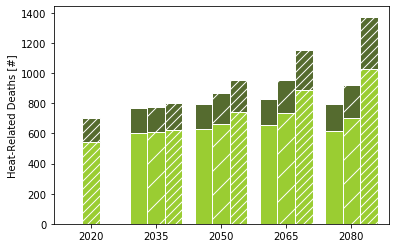

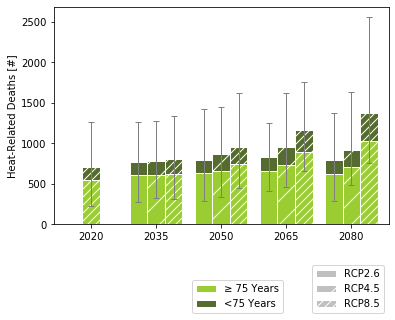

In [21]:
plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['≥ 75 Years','<75 Years'], save=True)

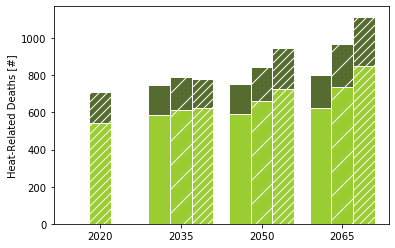

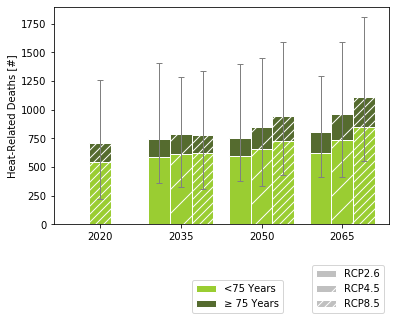

In [16]:
plot_impacts_heat(impacts_mortality1.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['<75 Years', '≥ 75 Years'], save=True, ratio=1)


In [ ]:
plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['≥ 75 Years', '<75 Years'], save=True, ratio=1)


In [24]:
impacts_mortality.agg_impacts_mc['RCP26'][2050]['Over 75'].median()

648.350360702523

In [23]:
np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Under 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'])


6.136357399216102e-06

In [73]:
def median_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.median(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts_mortality.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

In [82]:
print(percentile_death('RCP85', 2050, 40, category='all'))
print(percentile_death('RCP85', 2050, 60, category='all'))
print(median_death('RCP85', 2050))

print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 90, category='all'))
print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 95, category='all'))


875.4378377293702
999.9308141907652
953.1514787683086
-511.49952438256423
-666.5732108837751


## Spatial Impact

In [98]:
8237700/(exposures['Over 75']['total_population_canton'].unique().sum()+exposures['Under 75']['total_population_canton'].unique().sum())


0.5857433911084499

In [12]:
from src.write_entities.define_exposures import *

directory_exposures = '../../input_data/exposures/'
file_info='../../input_data/exposures/age_categories.csv'
file_locations='../../input_data/exposures/STATPOP2018.csv'
shp_cantons='../../input_data/shapefiles/KANTONS_projected_epsg4326/swissBOUNDARIES3D_1_3_TLM_KANTONSGEBIET_epsg4326.shp'
annual_deaths='../../input_data/impact_functions/annual_deaths.xlsx'

exposures_all = call_exposures_switzerland_mortality(file_info, file_locations, shp_cantons, annual_deaths, population_ratio=False, cantonal_average_deaths=False) #number of people instead of ratio

exposures = {}
exposures['Over 75'] = exposures_all[exposures_all['category']=='Over 75']
exposures['Over 75']  = Exposures(exposures['Over 75'] )
exposures['Under 75'] = exposures_all[exposures_all['category']=='Under 75']
exposures['Under 75']  = Exposures(exposures['Under 75'] )

2020-12-07 10:19:42,929 - climada.util.coordinates - INFO - Setting geometry points.
2020-12-07 10:20:30,470 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


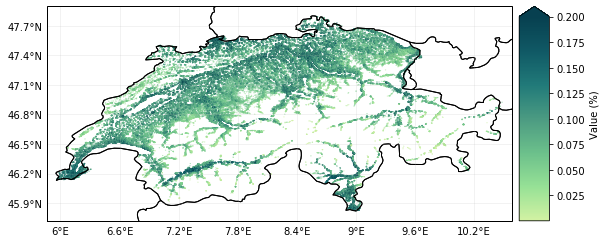

In [14]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures[category], percentage=True, unit='%')
impact.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=0.2, extend='max')

plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

## Relative change map

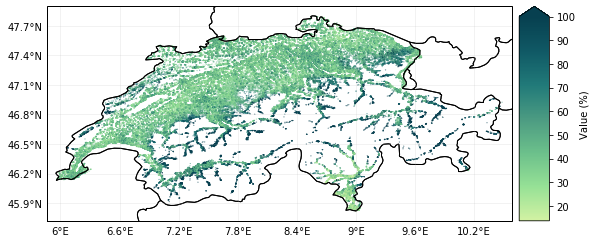

In [15]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

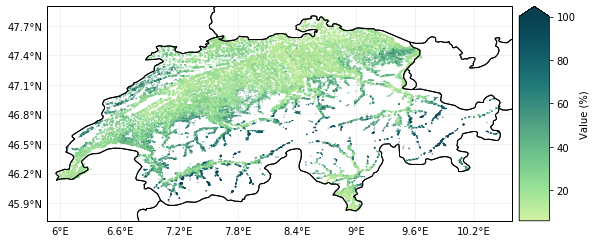

In [16]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP26'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='%')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, cmap=cm, buffer=0.1, vmax=100, extend='max')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75_rcp26.pdf']),bbox_inches='tight')

## Canton Impacts

In [37]:
agg_impact_zurich = impacts_mortality.calculate_impact_agg_canton('Zürich', exposures, impacts_mortality.categories)


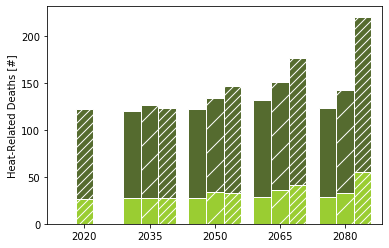

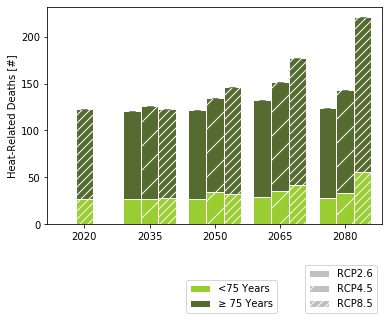

In [38]:
plot_impacts_heat(agg_impact_zurich, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['yellowgreen', 'darkolivegreen'], labels_cat=['<75 Years', '≥ 75 Years'], save=True)

In [34]:
plot_impacts_heat(agg_impact_zurich, 'Annual Heat Related Death (#)', uncertainty=False, color=['yellowgreen', 'darkolivegreen'],impact_type='mortality')



## Make Table with Cantonal Values

In [86]:
categories_short = {'Under 75':'<75', 'Over 75':'≥75'}    
cantonal_impacts_df = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP26','RCP45', 'RCP85'], years=[2020,2050,2080], categories_short=categories_short)


In [90]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)

In [49]:
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5'][2020])

In [67]:
cantonal_impacts_df['RCP8.5'][2020]['≥75']/(cantonal_impacts_df['RCP8.5'][2020]['≥75']+cantonal_impacts_df['RCP8.5'][2020]['<75'])
                                                                                                                           

canton
Aargau                    0.746396
Appenzell Ausserrhoden    0.812752
Appenzell Innerrhoden     0.814754
Basel-Landschaft          0.797994
Basel-Stadt               0.793417
Bern                      0.790317
Fribourg                  0.732610
Genève                    0.751273
Glarus                    0.799006
Graubünden                0.803963
Jura                      0.790286
Luzern                    0.761399
Neuchâtel                 0.797995
Nidwalden                 0.787109
Obwalden                  0.769569
Schaffhausen              0.780371
Schwyz                    0.776244
Solothurn                 0.770305
St. Gallen                0.776779
Thurgau                   0.753919
Ticino                    0.825921
Uri                       0.804212
Valais                    0.775077
Vaud                      0.764554
Zug                       0.762085
Zürich                    0.763937
Total                     0.773884
dtype: float64

In [70]:
cantonal_impacts_df_total

RCP2.6           RCP8.5           
                         2020 2050 2080   2020 2050  2080
canton                                                   
Aargau                     59   66   69     61   79   121
Appenzell Ausserrhoden      2    3    3      2    4     6
Appenzell Innerrhoden       0    0    0      0    1     1
Basel-Landschaft           29   33   34     30   39    59
Basel-Stadt                17   19   19     18   23    33
Bern                       86  101  100     89  119   179
Fribourg                   21   26   26     22   30    46
Genève                     41   46   47     44   58    88
Glarus                      2    3    2      2    3     5
Graubünden                 12   15   15     12   20    32
Jura                        6    8    8      7    9    14
Luzern                     29   34   33     30   40    60
Neuchâtel                  10   13   13     11   16    24
Nidwalden                   3    3    3      3    4     6
Obwalden                    2    2    2      2    3     5
Schaffhausen                7    8    9      8   10    16
Schwyz                      9   10   10      9   13    19
Solothurn                  26   30   31     27   36    55
St. Gallen                 34   40   40     35   49    72
Thurgau                    21   24   23     22   28    42
Ticino                     46   52   51     47   59    80
Uri                         2    2    2      2    3     5
Valais                     28   36   35     30   44    68
Vaud                       55   67   66     60   79   113
Zug                         7    8    8      7   10    15
Zürich                    109  122  123    112  146   220
Total                     676  782  787    704  937  1398

In [58]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{RCP2.6} & \multicolumn{3}{l}{RCP8.5} \\
{} &   2020 & 2050 & 2080 &   2020 & 2050 &  2080 \\
canton                 &        &      &      &        &      &       \\
\midrule
Aargau                 &     59 &   66 &   69 &     61 &   79 &   121 \\
Appenzell Ausserrhoden &      2 &    3 &    3 &      2 &    4 &     6 \\
Appenzell Innerrhoden  &      0 &    0 &    0 &      0 &    1 &     1 \\
Basel-Landschaft       &     29 &   33 &   34 &     30 &   39 &    59 \\
Basel-Stadt            &     17 &   19 &   19 &     18 &   23 &    33 \\
Bern                   &     86 &  101 &  100 &     89 &  119 &   179 \\
Fribourg               &     21 &   26 &   26 &     22 &   30 &    46 \\
Genève                 &     41 &   46 &   47 &     44 &   58 &    88 \\
Glarus                 &      2 &    3 &    2 &      2 &    3 &     5 \\
Graubünden             &     12 &   15 &   15 &     12 &   20 &    32 \\
Jura                   &      6 &    

In [88]:
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns=2020,level=1)

In [97]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])

canton
Aargau                     52
Appenzell Ausserrhoden      3
Appenzell Innerrhoden       1
Basel-Landschaft           25
Basel-Stadt                14
Bern                       79
Fribourg                   20
Genève                     41
Glarus                      3
Graubünden                 17
Jura                        6
Luzern                     27
Neuchâtel                  11
Nidwalden                   3
Obwalden                    3
Schaffhausen                7
Schwyz                      9
Solothurn                  24
St. Gallen                 32
Thurgau                    19
Ticino                     29
Uri                         3
Valais                     33
Vaud                       47
Zug                         7
Zürich                     97
Total                     611
Name: 2080, dtype: int64

In [101]:
cantonal_impacts_df_total['RCP2.6'][2080]

canton
Aargau                     69
Appenzell Ausserrhoden      3
Appenzell Innerrhoden       0
Basel-Landschaft           34
Basel-Stadt                19
Bern                      100
Fribourg                   26
Genève                     47
Glarus                      2
Graubünden                 15
Jura                        8
Luzern                     33
Neuchâtel                  13
Nidwalden                   3
Obwalden                    2
Schaffhausen                9
Schwyz                     10
Solothurn                  31
St. Gallen                 40
Thurgau                    23
Ticino                     51
Uri                         2
Valais                     35
Vaud                       66
Zug                         8
Zürich                    123
Total                     787
Name: 2080, dtype: int64

In [99]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])/(cantonal_impacts_df_total['RCP2.6'][2080])




canton
Aargau                    0.753623
Appenzell Ausserrhoden    1.000000
Appenzell Innerrhoden          inf
Basel-Landschaft          0.735294
Basel-Stadt               0.736842
Bern                      0.790000
Fribourg                  0.769231
Genève                    0.872340
Glarus                    1.500000
Graubünden                1.133333
Jura                      0.750000
Luzern                    0.818182
Neuchâtel                 0.846154
Nidwalden                 1.000000
Obwalden                  1.500000
Schaffhausen              0.777778
Schwyz                    0.900000
Solothurn                 0.774194
St. Gallen                0.800000
Thurgau                   0.826087
Ticino                    0.568627
Uri                       1.500000
Valais                    0.942857
Vaud                      0.712121
Zug                       0.875000
Zürich                    0.788618
Total                     0.776366
Name: 2080, dtype: float64

In [53]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


\begin{tabular}{lrrrrr}
\toprule
{} & Baseline (2020) & \multicolumn{2}{l}{RCP2.6} & \multicolumn{2}{l}{RCP8.5} \\
{} &   2050 & 2080 &   2050 &  2080 \\
canton                 &                 &        &      &        &       \\
\midrule
Aargau                 &              61 &     66 &   69 &     79 &   121 \\
Appenzell Ausserrhoden &               2 &      3 &    3 &      4 &     6 \\
Appenzell Innerrhoden  &               0 &      0 &    0 &      1 &     1 \\
Basel-Landschaft       &              30 &     33 &   34 &     39 &    59 \\
Basel-Stadt            &              18 &     19 &   19 &     23 &    33 \\
Bern                   &              89 &    101 &  100 &    119 &   179 \\
Fribourg               &              22 &     26 &   26 &     30 &    46 \\
Genève                 &              44 &     46 &   47 &     58 &    88 \\
Glarus                 &               2 &      3 &    2 &      3 &     5 \\
Graubünden             &              12 &     15 &   15 &     20 &